# Attempting some basic aperture photometry (yeet)

Based on method used in previous source detection test

First up, dependencies:

In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
from astropy.table import Column
from photutils import DAOStarFinder
from photutils import CircularAperture, CircularAnnulus
from photutils import aperture_photometry
from matplotlib.colors import LogNorm
#from astropy.visualization import SqrtStretch
#from astropy.visualization.mpl_normalize import ImageNormalize

Importing .fits file, extracting the ~ *data* ~, and converting the image to counts:

In [6]:
image_file = 'example_data/PAL5_3p6um.fits'
#image_file = 'data/PAL5/PAL5__e7/PAL5__e7_3p6um.fits'
image_data = fits.getdata(image_file, ext=0)
#print(image_data.shape)

hdu_list = fits.open(image_file)
hdr = hdu_list[0].header
#data = hdu_list[0].data   # could open data here instead of fits.getdata above, more consistent
exptime = hdr['EXPTIME']
fluxconv = hdr['FLUXCONV']
print(exptime, fluxconv)
hdu_list.close()

data = image_data * exptime / fluxconv

969.101928711 0.1469


Locating the objects in the image using DAOStarFinder, and plotting no. of stars detected vs. sigma curve:

In [3]:
#def detect_sources(data, sigma_level, FWHM):
#    daofind = DAOStarFinder(threshold = sigma_level * std, fwhm=FWHM)
#    sources = daofind(data - median)
#    return sources

Plotting the number of stars detected across a range of sigma values, allowing us to estimate the best sigma level to use:

In [18]:
mean, median, std = sigma_clipped_stats(data, sigma=4.) # don't need mean any more?

#detect_sources(data, sigma_level=5., FWHM=3.)
#for col in sources.colnames:
#    sources[col].info.format = '%.8g'
#print(sources)

#for i in range(1, 8):
#    detect_sources(data, sigma_level=float(i), FWHM=3.)
#    print(len(sources))

#no_detected = []
#sigma_vals = []
 
#for i in np.arange(1., 15.5, 0.5):
#    #print(i)
#    daofind = DAOStarFinder(threshold = i * std, fwhm = 3.)
#    sources = daofind(data - median)
#    #print(len(sources))
#    
#    no_detected.append(len(sources))
#    sigma_vals.append(i)
#
#print(no_detected)
#print(sigma_vals)

In [5]:
#plt.plot(sigma_vals, no_detected)
#plt.xlabel('sigma')
#plt.ylabel('number of sources detected')
#plt.grid(True)
#plt.savefig('images/sigma_curve_01.png', dpi=100)

Adding the centroid positions of the objects to an array and fitting circular apertures and annuli around them:

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


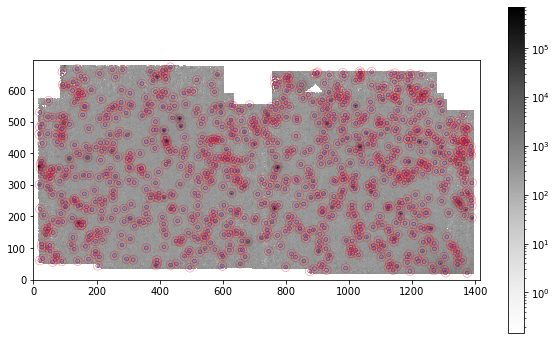

In [6]:
# 4 sigma seems ideal to me; fwhm = 3. is roughly the average of many stars tested with imexam (using 1d gaussian fit)
daofind = DAOStarFinder(threshold = 4. * std, fwhm = 3.)
sources = daofind(data - median)   # think: do i need to subtract bkg here? or later?

pos = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(pos, r=6.)
annuli = CircularAnnulus(pos, r_in=6., r_out=14.)
all_apers = [apertures, annuli]
norm = LogNorm()
plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
apertures.plot(color='blue', lw=.5, alpha=.5)
annuli.plot(color='red', lw=.5, alpha=.5)
plt.gcf().set_size_inches(10, 6)

#plt.title('4 sigma')
#plt.savefig('images/sigma_4.png', dpi=500)

Performing some basic aperture photometry, summing the pixel brightness values (fluxes?) inside each aperture and annulus:

(Note: 'nan' values for apertures are where the objects are too close to the edge of the image and use some pure white in their summation, and those for the annuli are where annuli overlap)

In [7]:
phot_table = aperture_photometry(data, all_apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

 id  xcenter   ycenter  aperture_sum_0 aperture_sum_1
       pix       pix                                 
--- --------- --------- -------------- --------------
  1  1374.715  21.00836            nan            nan
  2 1306.2872 21.691519            nan            nan
  3 1193.3978 26.582374      40170.307            nan
  4  875.5912 26.690492            nan            nan
  5 1269.2458 28.561557      92495.088            nan
  6 929.15178 29.723225      37404.056            nan
  7 1140.0222 29.913012      68417.435            nan
  8 1302.2448 30.489824      157632.94            nan
  9 890.49164 34.446212      36457.077      158338.43
 10 989.51277 35.887709      45001.038       159571.9
...       ...       ...            ...            ...
989 1071.7977 658.65453            nan            nan
990 91.637048 658.52925            nan            nan
991 1035.1634 660.07166            nan            nan
992 370.50076 660.02253      64689.982      180624.47
993 409.61314 662.66578     

Estimating the local background in the annuli by finding the mean brightness within:

In [8]:
bkg_mean = phot_table['aperture_sum_1'] / annuli.area
bkg_sum = bkg_mean * apertures.area
phot_table['bkg_sum'] = bkg_sum
final_sum = phot_table['aperture_sum_0'] - bkg_sum
phot_table['residual_sum_mean'] = final_sum

#for col in final_data.colnames:
#    final_data[col].info.format = '%.8g'
print(phot_table)

 id  xcenter   ycenter  ... aperture_sum_1  bkg_sum  residual_sum_mean
       pix       pix    ...                                           
--- --------- --------- ... -------------- --------- -----------------
  1  1374.715  21.00836 ...            nan       nan               nan
  2 1306.2872 21.691519 ...            nan       nan               nan
  3 1193.3978 26.582374 ...            nan       nan               nan
  4  875.5912 26.690492 ...            nan       nan               nan
  5 1269.2458 28.561557 ...            nan       nan               nan
  6 929.15178 29.723225 ...            nan       nan               nan
  7 1140.0222 29.913012 ...            nan       nan               nan
  8 1302.2448 30.489824 ...            nan       nan               nan
  9 890.49164 34.446212 ...      158338.43 35626.147         830.92974
 10 989.51277 35.887709 ...       159571.9 35903.677         9097.3615
...       ...       ... ...            ...       ...               ...
989 10

Alternate method: better stats yay (sigma-clipped median in the annuli):

In [9]:
annulus_masks = annuli.to_mask(method='center') # note: exact would be overkill for local bkg estimation (read ap phot tutorial for explanation)

bkg_median = []
for mask in annulus_masks:
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0]
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)

bkg_median = np.array(bkg_median)
#phot = aperture_photometry(data, apertures)
phot_table['annulus_median'] = bkg_median
phot_table['aper_bkg'] = bkg_median * apertures.area
phot_table['aper_sum_bkgsub'] = phot_table['aperture_sum_0'] - phot_table['aper_bkg']

for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

 id  xcenter   ycenter  ... annulus_median  aper_bkg aper_sum_bkgsub
       pix       pix    ...                                         
--- --------- --------- ... -------------- --------- ---------------
  1  1374.715  21.00836 ...      767.60413 86813.981             nan
  2 1306.2872 21.691519 ...      941.07599 106433.19             nan
  3 1193.3978 26.582374 ...      418.83795 47369.456      -7199.1495
  4  875.5912 26.690492 ...      313.18938 35420.884             nan
  5 1269.2458 28.561557 ...      639.06165 72276.169       20218.918
  6 929.15178 29.723225 ...      294.53822 33311.488       4092.5678
  7 1140.0222 29.913012 ...      408.80429 46234.676       22182.759
  8 1302.2448 30.489824 ...      894.32312 101145.56       56487.382
  9 890.49164 34.446212 ...      312.03087  35289.86       1167.2173
 10 989.51277 35.887709 ...      316.91534 35842.281       9158.7572
...       ...       ... ...            ...       ...             ...
989 1071.7977 658.65453 ...      2

Trying to calculate the apparent magnitudes of each star:

I think the negative 'aper_sum_bkgsub's happen in crowded areas where the annulus counts another star as the background, so the bkg value is larger than the aperture sum, or where the star itself is so dim the bkg est is higher, or a mix of both. Does this mean I need a higher threshold or fwhm to rule out the dim boyos? Who knows

In [23]:
flux_zeromag = 280.9         # from Reach et al 2005, section 5.4; for 3.6 band, = 280.9 +/- 4.1
zmag = 18.8                  # given in/calculated using IRAC handbook, section 4.8
aperture_correction = 1.125  # for 6, 6-14 pix apertures in channel 1; given in IRAC handbook, table 4.7
negative_sums = []

phot_table['apparent_mag_mean'] = float('NaN')
phot_table['apparent_mag_median'] = float('NaN')   # idk why i have to fill the new column with NaNs first but hey ho it works

for i in range(0, len(phot_table)):
    if phot_table['residual_sum_mean'][i] >= 0:
        phot_table['apparent_mag_mean'][i] = aperture_correction * (zmag - 2.5 * math.log10(phot_table['residual_sum_mean'][i]))
    if phot_table['aper_sum_bkgsub'][i] >= 0:
        phot_table['apparent_mag_median'][i] = aperture_correction * (zmag - 2.5 * math.log10(phot_table['aper_sum_bkgsub'][i]))
    else:
        negative_sums.append(phot_table['id'][i])

for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)
#print(negative_sums)

print(np.count_nonzero(~np.isnan(phot_table['apparent_mag_mean'])))
print(np.count_nonzero(~np.isnan(phot_table['apparent_mag_median'])))

 id  xcenter   ycenter  ... apparent_mag_mean apparent_mag_median
       pix       pix    ...                                      
--- --------- --------- ... ----------------- -------------------
  1  1374.715  21.00836 ...               nan                 nan
  2 1306.2872 21.691519 ...               nan                 nan
  3 1193.3978 26.582374 ...               nan                 nan
  4  875.5912 26.690492 ...               nan                 nan
  5 1269.2458 28.561557 ...               nan           9.0400559
  6 929.15178 29.723225 ...               nan           10.991262
  7 1140.0222 29.913012 ...               nan           8.9268313
  8 1302.2448 30.489824 ...               nan           7.7851366
  9 890.49164 34.446212 ...         12.938725           12.523636
 10 989.51277 35.887709 ...          10.01555           10.007335
...       ...       ... ...               ...                 ...
989 1071.7977 658.65453 ...               nan                 nan
990 91.637

In [ ]:
#phot.write('outputs/phot_table_e1.txt', format='csv', overwrite=True)